Pois categories:
- entertainment
- commercial
- catering
- service
- office
- leisure
- natural
- education
- building.historic
- heritage
- tourism
- accomodation
- pet
- healthcare
- administrative
- production
- religion
- amenity
- public transport

Nodes features:
- crosswalk
- walk light
- round-about
- walk light duration
- street width
- tactile paving

Edges features:
- work in progress
- bike lane
- uphill
- surface
- one way
- tactile paving
- stairs

Pois features:
- wheelchair accessible
- tactile paving
- tactile map
- reception
- stairs
- elevators

In [491]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import json

In [492]:
src = "detroit_conant"
out = f"{src}/{src}_out"

In [493]:
!python3.8 src/convert_new_york_pois.py  --src_dir "{src}" --feets_per_inch 333.33

Seed: 1726008072.060359
Street not found: West 31st Street
New York references found in Prosek
New York references found in Grand Vista Hotel


In [494]:
fixes = {
    "Cooper Electric": "Joseph Campau Avenue",
    "The Lincoln Detroit": "Klinger Street",
    "Urban Fusion": "East Robinwood Street",
    "Wells Fargo": "East Grixdale Avenue",
    "Whole Foods Market": "East Grixdale Avenue",
    "Wolfgang’s Steakhouse": "Brinker Avenue",
}

with open(f"{src}/pois.json") as f:
    pois_raw = json.load(f)

for poi in pois_raw["features"]:
    poi = poi["properties"]
    if not "name" in poi:
        continue

    if poi["name"] in fixes:
        if "branch" in poi and poi["branch"] == poi["street"]:
            poi["branch"] = fixes[poi["name"]]
        poi["street"] = fixes[poi["name"]]

with open(f"{src}/pois.json", "w") as f:
    json.dump(pois_raw, f, indent=4)

In [495]:
!python3.8 src/format.py --name "Detroit, Conant Street" --n0 1 --n1 "(2, 42.43049082474931, -83.07592347811368)" --d_feets 803.87 --feets_per_inch 333.33 --src_dir "{src}"

Feets per pixel: 2.42059254136372
Skipping POI without name at index 3
Skipping POI without name at index 6
Skipping POI without name at index 9
Skipping POI without name at index 13
Skipping POI without name at index 18
Could not find edge for Wells Fargo
Valley Bank (52) is too close to node 23
Antioch Missionary Baptist Church (1) is too close to node 25
Nomad (34) is too close to node 27
Jewelry Shopping Mall (26) is too close to node 65
Conant / 7 Mile (NB) (8) is too close to node 66
Conant / 7 Mile (NB) (8) is too close to node 67
Conant / Grixdale (SB) (11) is too close to Conant Gardens Church of Christ (15)
Conant / Kalsh (NB) (12) is too close to Food Gallery 32 (20)
Conant Ave United Methodist Church (14) is too close to Kosher (29)
Conant Ave United Methodist Church (14) is too close to Nomad (34)
Conant Gardens Church of Christ (15) is too close to Stout Detroit (42)
Cooper Electric (16) is too close to United Grill Coney Island (50)
Eden Crest (19) is too close to Stout 

In [496]:
def distance(p1, p2):
    return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)**0.5

def get_label(name: str):
    name.replace("-", " ")
    name.replace("_", " ")

    label = ""
    for word in name.split(" "):
        if len(word) > 2 and word[:-2].isnumeric():
            label += word[:-2]
        else: label += word[0]
    return label

def get_contrasting_color(color):
    rgb = mcolors.to_rgb(color)
    brightness = 0.299 * rgb[0] + 0.587 * rgb[1] + 0.114 * rgb[2]
    return 'white' if brightness < 0.5 else 'black'

In [497]:
G = nx.Graph()

with open(f'{out}/nodes.json') as f:
    nodes = json.load(f)

for i, node in enumerate(nodes):
    G.add_node(i, pos=(node[0], node[1]))

with open(f'{out}/edges.json') as f:
    edges = json.load(f)

with open(f'{out}/streets.json', 'r') as f:
    streets = json.load(f)

for street, street_edges in streets.items():
    street = street.replace("Street", "St")
    street = street.replace("Avenue", "Ave")
    street = street.replace("Boulevard", "Blvd")
    street = street.replace("Road", "Rd")

    for edge_index in street_edges:
        edge = edges[edge_index]

        n1 = G.nodes[edge[0]]['pos']
        n2 = G.nodes[edge[1]]['pos']
        dist = distance(n1, n2)
        G.add_edge(edge[0], edge[1], weight=dist, street=street)

with open(f'{out}/pois.json') as f:
    pois = json.load(f)

print(f"PoIs found: {len(pois)}")

PoIs found: 58


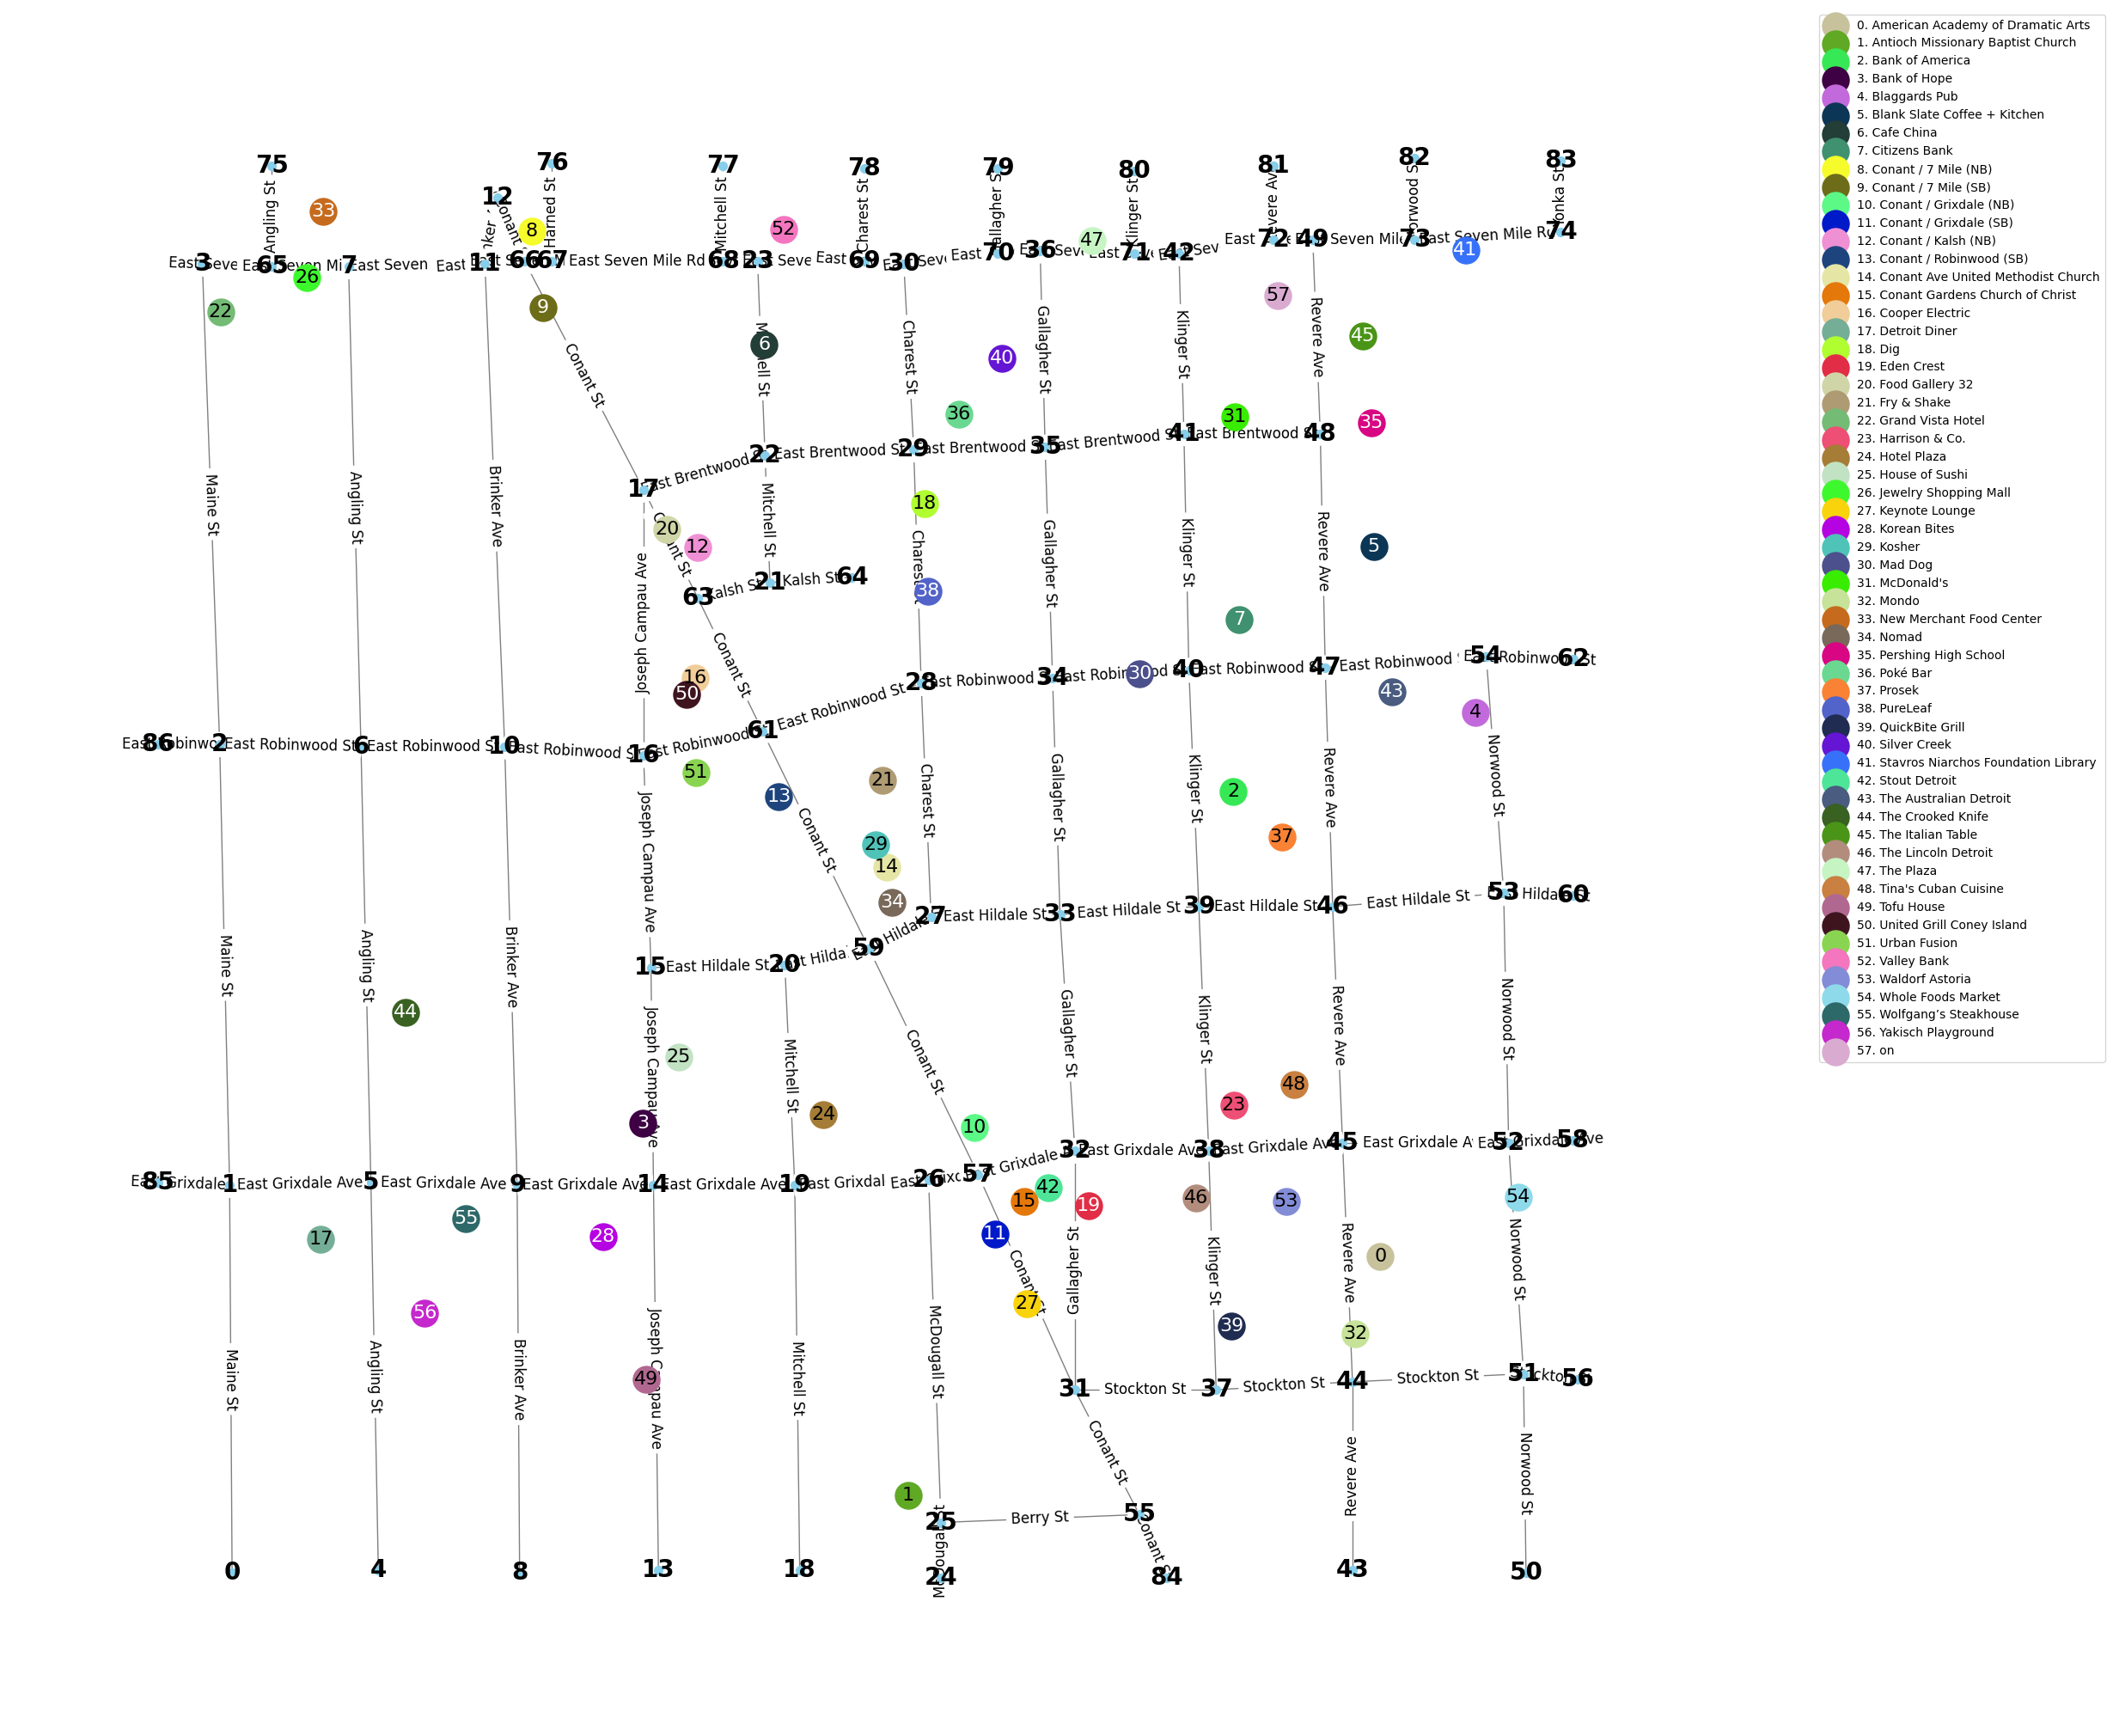

In [498]:
pos = nx.get_node_attributes(G, "pos")

plt.figure(figsize=(20, 20))

nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=50,
    node_color="skyblue",
    font_size=20,
    font_color="black",
    font_weight="bold",
    edge_color="gray",
)

labels = nx.get_edge_attributes(G, "street")
#labels = {k: round(v, 2) for k, v in labels.items()}
#labels = {k: get_label(v) for k, v in labels.items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=12)

colors = np.random.rand(len(pois), 3)
for i, poi in enumerate(pois):
    coords = poi["coords"]
    dot = plt.scatter(
        coords[0], coords[1], color=colors[i], s=500, label=f"{i}. {poi['name']}"
    )
    text_color = get_contrasting_color(colors[i])
    plt.text(coords[0], coords[1], i, fontsize=16, c=text_color, ha="center", va="center")

plt.gca().invert_yaxis()
plt.gcf().set_size_inches(20, 20)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.savefig(f"{out}/plot.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

In [499]:
offset = 0
for i, poi in enumerate(pois[offset:]):
    print(f"{i + offset}. {poi['name']} - {edges[poi['edge']]}")

0. American Academy of Dramatic Arts - [44, 45]
1. Antioch Missionary Baptist Church - [25, 26]
2. Bank of America - [39, 40]
3. Bank of Hope - [14, 15]
4. Blaggards Pub - [47, 54]
5. Blank Slate Coffee + Kitchen - [47, 48]
6. Cafe China - [22, 23]
7. Citizens Bank - [40, 41]
8. Conant / 7 Mile (NB) - [66, 12]
9. Conant / 7 Mile (SB) - [17, 66]
10. Conant / Grixdale (NB) - [57, 59]
11. Conant / Grixdale (SB) - [31, 57]
12. Conant / Kalsh (NB) - [63, 17]
13. Conant / Robinwood (SB) - [59, 61]
14. Conant Ave United Methodist Church - [59, 61]
15. Conant Gardens Church of Christ - [31, 57]
16. Cooper Electric - [16, 17]
17. Detroit Diner - [4, 5]
18. Dig - [28, 29]
19. Eden Crest - [32, 38]
20. Food Gallery 32 - [16, 17]
21. Fry & Shake - [27, 28]
22. Grand Vista Hotel - [2, 3]
23. Harrison & Co. - [38, 39]
24. Hotel Plaza - [19, 20]
25. House of Sushi - [14, 15]
26. Jewelry Shopping Mall - [6, 7]
27. Keynote Lounge - [31, 57]
28. Korean Bites - [13, 14]
29. Kosher - [59, 61]
30. Mad Dog 

In [500]:
edges[33]

[47, 48]